In [36]:
#!/usr/bin/env python
# coding: utf-8

%conda install bottleneck
%conda install nc-time-axis

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bottleneck as bn
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt
import xarray as xr
import nc_time_axis
import cftime
import warnings
warnings.simplefilter('ignore')
import datetime

%matplotlib inline

In [38]:
def bn_mov_mean(data,width):
    return bn.move_mean(a=data,window=width,min_count = 1)

def is_jj(month):
    return (month >= 6) & (month <= 7)

### Reading tuna larvae dataset 

In [39]:
fname = r'DEEPEND_Dataset_tunas.xlsx'

df = pd.read_excel(fname,na_values=-99999)

# Getting the data without NA
tunaLarvae = df['Th_NN500'].dropna()
idx = np.where(tunaLarvae != np.nan)
sal = df['Salinity'][idx[0][:]].fillna(method='ffill')

# Removing all data based on the idx of tunaLarvae and filling the NaN regions using previous values
# removing values where salinity is greater than 40 for all variables
lat = df['Latitude (DD)'][idx[0][:]].fillna( method ='ffill') 
lat = lat[sal < 40]
lon = df['Longitude (DD)'][idx[0][:]].fillna( method ='ffill') 
lon = lon[sal < 40]
date = df['Collection date'][idx[0][:]].fillna( method ='ffill') 
date = date[sal < 40]
sst = df['SST (°C)'][idx[0][:]].fillna( method ='ffill') 
sst = sst[sal < 40]
ssh = df['SSHA (cm)'][idx[0][:]].fillna( method ='ffill') 
ssh = ssh[sal < 40]/100

tunaLarvae = tunaLarvae[sal < 40]
tuna = np.zeros((tunaLarvae.shape[0],1))
tuna[:,0] = tunaLarvae
sal = sal[sal < 40]

#################### 
Var_b = np.zeros((lat.shape[0],3))
Var_b[:,0] = sst 
Var_b[:,1] = ssh
Var_b[:,2] = sal 

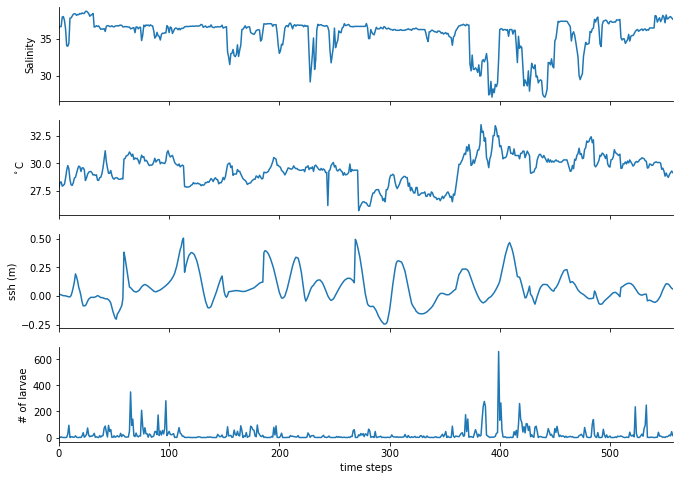

In [40]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    figsize=(11, 8),
    nrows=4,
    sharex=True,
)

sal.plot(ax=ax0); ax0.set_ylabel('Salinity')
sst.plot(ax=ax1); ax1.set_ylabel('$^\circ$C')
ssh.plot(ax=ax2); ax2.set_ylabel('ssh (m)')
tunaLarvae.plot(ax=ax3); ax3.set_ylabel('# of larvae'); ax3.set_xlabel('time steps')

ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(True)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(True)

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(True)

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(True)

### Smoothing dataset before ML training

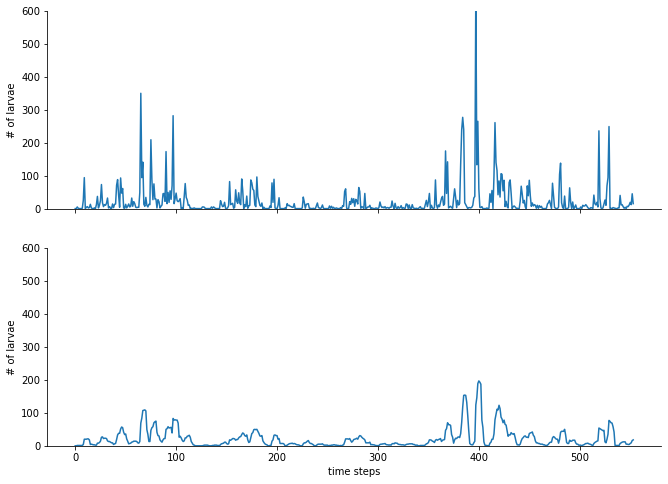

In [41]:
tunaSmooth = bn_mov_mean(tunaLarvae,6)
tunaVec = np.vectorize(np.int)
tunaSmooth = tunaVec(tunaSmooth)

fig, (ax0, ax1) = plt.subplots(
    figsize=(11, 8),
    nrows=2,
    sharex=True,
)

ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(True)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(True)
ax0.set_ylim(0,600)
ax0.set_ylabel('# of larvae'); 

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.set_xlabel('time steps')
ax1.set_ylabel('# of larvae'); 
ax1.set_ylim(0,600)

ax0.plot(range(0,len(tunaLarvae)),tunaLarvae); 

ax1.plot(range(0,len(tunaLarvae)), tunaSmooth)

### Spliting into training and validation data

In [64]:
nData = 250
#seed = 10

var_train, var_validation, tuna_train, tuna_validation = train_test_split(Var_b[nData:,:], tunaSmooth[nData:], test_size=0.15)#, random_state=seed)

### Estimating the best parameters for ML model

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model

rf_random.fit(var_train, tuna_train)
print()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.7min


### ML training and validation

In [60]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [rf_random.best_params_['bootstrap']],
    'max_depth': [rf_random.best_params_['max_depth']],
    'max_features': [rf_random.best_params_['max_features']],
    'min_samples_leaf': [rf_random.best_params_['min_samples_leaf']],
    'min_samples_split': [rf_random.best_params_['min_samples_split']],
    'n_estimators': [rf_random.best_params_['n_estimators']]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(var_train, tuna_train)
tuna_val = grid_search.predict(var_validation)

grid_search.best_estimator_.feature_importances_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


array([0.32857957, 0.35843486, 0.31298557])

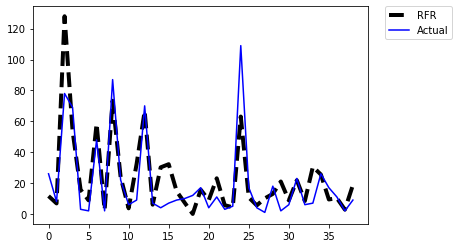

In [61]:
plt.plot(range(0,len(tuna_val)),tuna_val,'k--',linewidth=4,label="RFR")
plt.plot(range(0,len(tuna_validation)),tuna_validation,'b',label="Actual")  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

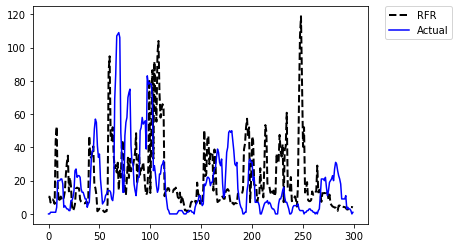

In [62]:
tuna_val = grid_search.predict(Var_b[:nData,:])

plt.plot(range(0,len(tuna_val)),tuna_val,'k--',linewidth=2,label="RFR")
plt.plot(range(0,len(tunaSmooth[:nData])),tunaSmooth[:nData],'b',label="Actual")  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#rms = sqrt(mean_squared_error(fpad[nData:], tuna_val))
#rms

In [54]:
BASE = "http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/"
EXP = "ScenarioMIP/NCAR/CESM2/ssp585/r1i1p1f1/Omon/"
VAR = ["thetao" , "so" , "zos"]
GRID = "/gr/v20190730/"
#SUFFIX = ["_Omon_CESM2_ssp585_r1i1p1f1_gr_201501-206412.nc",\
#           "_Omon_CESM2_ssp585_r1i1p1f1_gr_206501-210012.nc"]
#for j in SUFFIX:

SUFFIX1 = "_Omon_CESM2_ssp585_r1i1p1f1_gr_201501-206412.nc"
SUFFIX2 = "_Omon_CESM2_ssp585_r1i1p1f1_gr_206501-210012.nc"
          
ds_surf1 = xr.Dataset()
for i in VAR:    
    url = BASE + EXP + i + GRID + i + SUFFIX1
    ds = xr.open_dataset(url)
    lat = ds['lat']
    lon = ds['lon']
    time = ds['time']
    
    try:
        surf = ds[i].sel(lev = 0, lat=slice(26,28), lon=slice(267,274))
        surf = surf.sel(time=is_jj(surf['time.month'])).mean(dim = ('lon','lat')).drop('lev')          
        surf.name = ['surf_' + i]
        ds_surf1['surf_' + i] = surf
    except:
        surf = ds[i].sel(lat=slice(26,28), lon=slice(267,274))
        surf = surf.sel(time=is_jj(surf['time.month'])).mean(dim = ('lon','lat'))
        surf.name = ['surf_' + i]
        ds_surf1['surf_' + i] = surf

ds_surf2 = xr.Dataset()
for i in VAR:    
    url = BASE + EXP + i + GRID + i + SUFFIX2
    ds = xr.open_dataset(url)
    lat = ds['lat']
    lon = ds['lon']
    time = ds['time']
    
    try:
        surf = ds[i].sel(lev = 0, lat=slice(26,28), lon=slice(267,274))
        surf = surf.sel(time=is_jj(surf['time.month'])).mean(dim = ('lon','lat')).drop('lev')          
        surf.name = ['surf_' + i]
        ds_surf2['surf_' + i] = surf
    except:
        surf = ds[i].sel(lat=slice(26,28), lon=slice(267,274))
        surf = surf.sel(time=is_jj(surf['time.month'])).mean(dim = ('lon','lat'))
        surf.name = ['surf_' + i]
        ds_surf2['surf_' + i] = surf

ds_surf = xr.auto_combine([ds_surf1, ds_surf2])

In [55]:
### Getting data ready for prediction
sstCMIP6 = ds_surf['surf_thetao'][:]
salCMIP6 = ds_surf['surf_so'][:]
sshCMIP6 = ds_surf['surf_zos'][:]

VarCMIP6 = np.zeros((sstCMIP6.shape[0],3))
VarCMIP6[:,0] = bn_mov_mean(sstCMIP6,2) 
VarCMIP6[:,1] = sshCMIP6 
VarCMIP6[:,2] = salCMIP6 

Text(0.5, 0, 'Years')

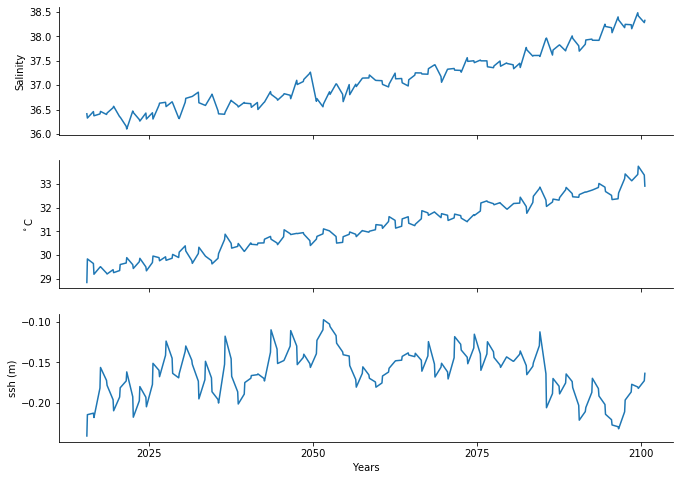

In [56]:
fig, (ax0, ax1, ax2) = plt.subplots(
    figsize=(11, 8),
    nrows=3,
    sharex=True,
)

ax0.plot(ds_surf['time'],salCMIP6); 

ax1.plot(ds_surf['time'],bn_mov_mean(sstCMIP6,2)); 

ax2.plot(ds_surf['time'],bn_mov_mean(sshCMIP6,2)); 

ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(True)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(True)
ax0.set_ylabel('Salinity')

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.set_ylabel('$^\circ$C')

ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(True)
ax2.set_ylabel('ssh (m)')
ax2.set_xlabel('Years')

Text(0.5, 0, 'Years')

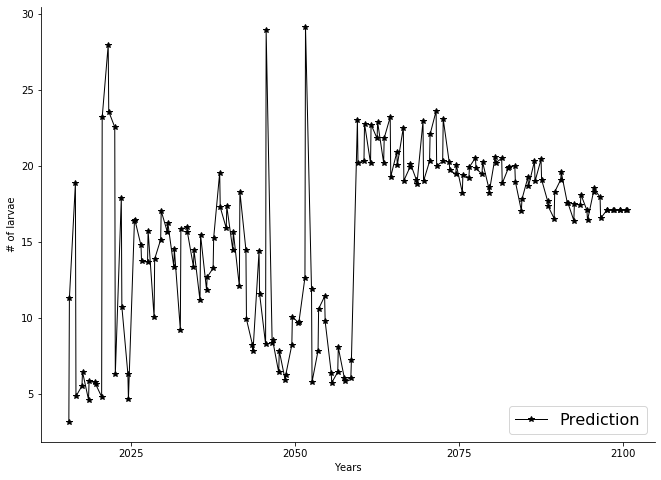

In [63]:
tuna_val = grid_search.predict(VarCMIP6)

fig, ax = plt.subplots(
    figsize=(11, 8),
    nrows=1,
    sharex=True,
)

ax.plot(ds_surf['time'],signal.medfilt(tuna_val,1),'k*-',linewidth=1,label="Prediction") 
plt.legend(loc='lower right',fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.set_ylabel('# of larvae')
ax.set_xlabel('Years')


# Sources:

# - Valentina
## https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
## https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
## https://data.gulfresearchinitiative.org/data/R4.x257.000:0010
## http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/


# Next steps:

### Better way to clean up the data used for training and validation
### More data for the training set needed
### Use Dask for parallelization of ML parameter estimator
